In [7]:
#Setting up the connection

In [1]:
from breeze_connect import BreezeConnect
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
import scipy.stats as scs
import statsmodels.api as sm
from pylab import mpl, plt

In [2]:
breeze = BreezeConnect(api_key = 'ge528J31807C23m1138209727YT28K7*')

In [3]:
import urllib
print("https://api.icicidirect.com/apiuser/login?api_key="+urllib.parse.quote_plus("ge528J31807C23m1138209727YT28K7*"))


https://api.icicidirect.com/apiuser/login?api_key=ge528J31807C23m1138209727YT28K7%2A


In [4]:
breeze.generate_session(api_secret="7$`4002714a8v&50&014906179j^4881",
                        session_token="20501958")

In [198]:
#Constants

In [5]:
RF = 3
TIMEDELTA = 365

In [8]:
#Portfolio

In [44]:
# data_dict = {}
# format = '%Y-%m-%d'
# datetime.datetime.strptime('2023-03-01', format).date()
dict = breeze.get_historical_data(interval="1day", from_date="2023-03-01T07:00:00.000Z", to_date="2023-03-31T07:00:00.000Z", stock_code='HDFBAN', exchange_code="NSE", product_type="cash")
df = pd.DataFrame([[x['datetime'][:10], float(x['close'])] for x in dict['Success']], columns = ['Date', 'HDFBAN'])
df.head()
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
data_dict['HDFBAN'] = df.set_index('Date')
data_dict

{'HDFBAN':              HDFBAN
 Date               
 2023-03-01  1598.05
 2023-03-02  1584.45
 2023-03-03  1615.90
 2023-03-06  1627.30
 2023-03-08  1630.55
 2023-03-09  1630.70
 2023-03-10  1588.65
 2023-03-13  1568.55
 2023-03-14  1564.35
 2023-03-15  1541.90
 2023-03-16  1551.90
 2023-03-17  1572.65
 2023-03-20  1561.75
 2023-03-21  1579.45
 2023-03-22  1575.80
 2023-03-23  1563.15
 2023-03-24  1560.65
 2023-03-27  1567.45
 2023-03-28  1580.20
 2023-03-29  1587.80
 2023-03-31  1609.55}

datetime.date(2023, 3, 1)

In [45]:

def get_cov_mat(stocks, from_date="2013-04-01T07:00:00.000Z", to_date="2023-03-31T07:00:00.000Z"):
    data_dict = {}    
    for stock in stocks:
        dict = breeze.get_historical_data(interval="1day", from_date=from_date, to_date=to_date, stock_code=stock, exchange_code="NSE", product_type="cash")
        #data_dict[stock]=[{'date': x['datetime'][:10], 'close': x['close']} for x in dict['Success']]
        df = pd.DataFrame([[x['datetime'][:10], float(x['close'])] for x in dict['Success']], columns = ['Date', stock])
        df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
        data_dict[stock] = df.set_index('Date')
    
    data = []
    for key in data_dict:
        data.append(data_dict[key])

    price_data = pd.concat(data, axis=1, join='inner')
    
    index_data = price_data[['NIFTY']]
    price_data = price_data.drop(['NIFTY'], axis=1)

    log_ret = np.log(price_data/price_data.shift(1))

    cov_mat = log_ret.cov()
    cov_mat = cov_mat*252  #assuming 252 trading days in a year
    ret = (log_ret.mean()+1)**252-1
    

    return price_data, index_data, cov_mat, ret

In [1]:
import numpy as np

In [4]:
(np.log(130/100)/3+1)**3-1

0.2859781500777878

In [5]:
1.3**(1/3)

1.091392883061106

In [7]:
def amt_to_wt(amounts):
    total=sum(amounts)
    return np.array([a/total for a in amounts])

In [18]:
tickermatch = pd.read_csv('MCAP.csv', index_col='Symbol').to_dict()['ShortName']

In [13]:
price_data, index_data, cov_mat, ret = get_cov_mat([tickermatch['HDFCBANK'], tickermatch['ITC'], 'NIFTY'])

In [14]:
print(price_data.head())
print(index_data.head())
print(cov_mat)
print(ret)

            HDFBAN     ITC
Date                      
2013-04-01  311.93  204.80
2013-04-02  314.95  204.77
2013-04-03  311.83  205.07
2013-04-04  308.08  199.70
2013-04-05  310.48  194.20
              NIFTY
Date               
2013-04-01  5704.40
2013-04-02  5748.10
2013-04-03  5672.90
2013-04-04  5574.75
2013-04-05  5553.25
          HDFBAN       ITC
HDFBAN  0.056462  0.019466
ITC     0.019466  0.068517
HDFBAN    0.183145
ITC       0.066417
dtype: float64


In [46]:
class Portfolio(object):
    def __init__(self, secs, weights):

        self.secs = secs
        self.weights = weights

        self.pdata, self.idata, cov_mat, returns  = get_cov_mat(self.secs)

        self.ret = round(np.dot(returns, self.weights)*100, 2)
        self.std = round(np.sqrt(np.dot(self.weights.T, np.dot(cov_mat, self.weights.T)))*100, 2)
        self.sharpe = round((self.ret-RF)/self.std,2)

    def __str__(self):
        return f"Returns: {self.ret}% Std: {self.std}%"

    def plot_performance(self):
        index = 100
        ind_val=[index]
        day = self.weights*100
        port_val = []
        port_val.append(day.sum())

        piret = self.pdata/self.pdata.shift(1)
        inret = self.idata/self.idata.shift(1)

        for i in range(1, len(piret)):
            day = np.array(day*piret.iloc[i])
            port_val.append(day.sum())
            index = index*inret.iloc[i][0]
            ind_val.append(index)
        
        self.pdata['port_val'] = port_val
        self.pdata['ind_val'] = ind_val
        
        index_return = ((np.log(self.idata/self.idata.shift(1)).mean()+1)**252-1)[0]
        std_return_diff = np.std(self.pdata['port_val']/self.pdata['port_val'].shift(1)-self.pdata['ind_val']/self.pdata['ind_val'].shift(1))
        self.inf = (self.ret/100-index_return)/std_return_diff
        
        plt.plot(self.pdata['port_val'], label="Portfolio")
        plt.plot(self.pdata['ind_val'], label="Nifty")
        sns.lineplot(self.pdata['port_val'])
        #plt.savefig('media\plot.png')


In [47]:
def compute_portfolio(ticks, amounts):
    if len(ticks) == 0:
        return 0, 0
    secs = [tickermatch[tick] for tick in ticks]
    port = Portfolio(secs, amt_to_wt(amounts))
    port.plot_performance()
    print(port.pdata)
    


               ITC   HDFBAN   ASIPAI    port_val     ind_val
Date                                                        
2013-04-01  204.80   311.93   495.50  100.000000  100.000000
2013-04-02  204.77   314.95   489.04   99.908784  100.766075
2013-04-03  205.07   311.83   488.51   99.705229   99.447795
2013-04-04  199.70   308.08   478.86   97.606764   97.727193
2013-04-05  194.20   310.48   476.76   96.350388   97.350291
...            ...      ...      ...         ...         ...
2023-03-24  378.70  1560.65  2798.50  358.731963  297.052275
2023-03-27  380.20  1567.45  2803.75  359.908052  297.764883
2023-03-28  379.75  1580.20  2784.45  359.846288  297.168852
2023-03-29  382.75  1587.80  2770.50  360.483987  299.430264
2023-03-31  383.50  1609.55  2761.65  361.963753  304.322102

[2459 rows x 5 columns]


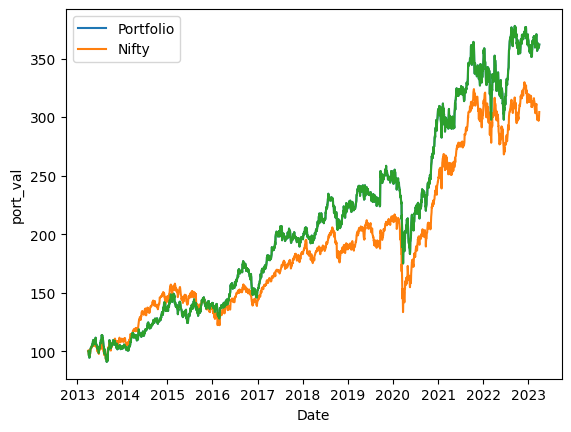

In [48]:
compute_portfolio(['ITC', 'HDFCBANK', 'ASIANPAINT', 'NIFTY 50'], [200, 100, 100])